In [5]:
%matplotlib inline
import numpy as np
# a python module handling graph manipulations
import networkx as nx

from mocpy import MOC
from mocpy.spatial.utils import make_wcs

from astropy_healpix import HEALPix

from astropy.coordinates import ICRS, SkyCoord
from astropy.wcs.utils import skycoord_to_pixel

In [6]:
order = 6

fits_path = 'demo-data/P-SDSS9-r.fits'
moc = MOC.from_fits(fits_path)
moc = moc.degrade_to_order(order)

/home/baumann/.local/lib/python3.6/site-packages/astropy_healpix/core.py:592: RuntimeWarning: invalid value encountered in neighbours_nested
  return np.stack(func(healpix_index, nside))


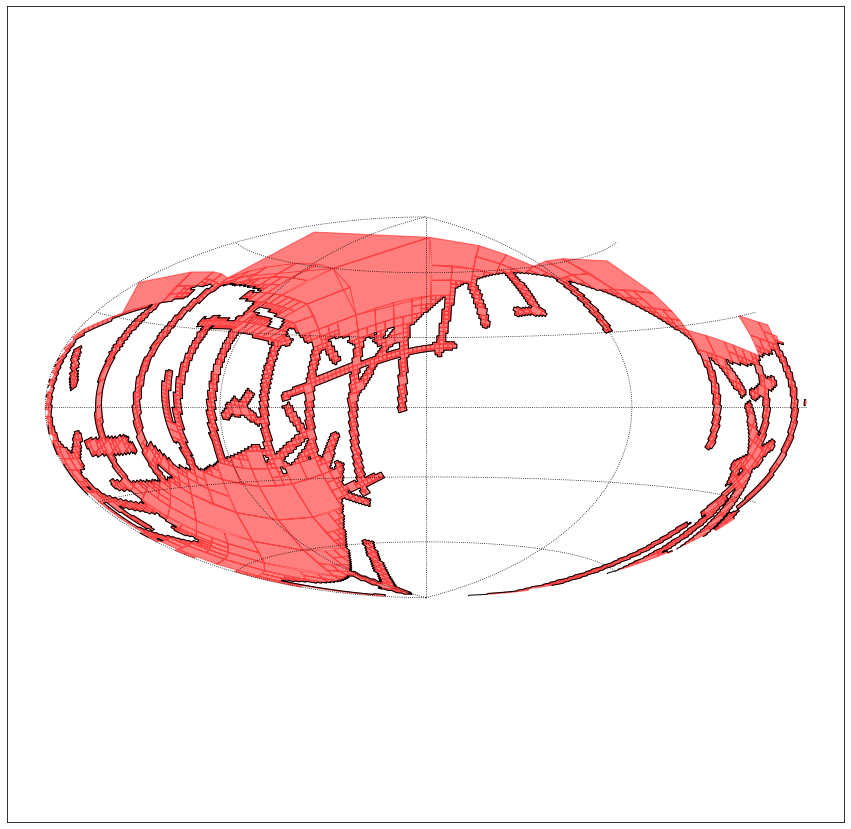

In [9]:
# A function creating all the matplotlib context for plotting a MOC with its perimeter
def plot(moc, wcs, title=''):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": wcs})
    moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color='r')
    moc.border(ax=ax, wcs=wcs, color='black')

    plt.axis('equal')
    plt.xlabel('ra')
    plt.ylabel('dec')
    if title:
        plt.title(title)
    plt.grid(color="black", linestyle="dotted")
    plt.show()
    plt.close()


wcs_galactic = make_wcs(crpix=[0, 0], crval=[0, 0], cdelt=[-5, 5], ctype=["GLON-AIT", "GLAT-AIT"])
plot(moc, wcs_galactic)

In [10]:
if moc.max_order > 8:
    moc = moc.degrade_to_order(8)

max_order = moc.max_order
hp = HEALPix(nside=(1 << max_order), order='nested', frame=ICRS())
ipixels_open = moc._best_res_pixels()

# Take the complement if the MOC covers more than half of the sky => the perimeter(MOC) = perimeter(complement(MOC))
# but we process less hpx cells
num_ipixels = 3 << (2*(max_order + 1))
sky_fraction = ipixels_open.shape[0] / float(num_ipixels)

if sky_fraction > 0.5:
    ipixels_all = np.arange(num_ipixels)
    ipixels_open = np.setdiff1d(ipixels_all, ipixels_open, assume_unique=True)

In [11]:
# Faster version for computing the graph of all the connected ipixels
def build_graph_from_ipixels(ipixels, dir_connected=[0, 2, 4, 6]):
    """
    Build a graph from a list of ipixels
    
    The connexion relation between a node and its neighbours can be specified.
    By default, each ipix is only connected to its direct neighbours (e.g. 
    west, south, east and north)
    """
    neighbours = hp.neighbours(ipixels)
    # Select only the WEST, SOUTH, EAST and NORTH neighbours (i.e. the direct ones)
    neighbours = neighbours[dir_connected, :]

    # Select only neighbours lying in the ipixels ensemble
    mask = np.isin(neighbours, ipixels)
    edges = np.array([])
    i = 0
    for k in dir_connected:
        mask_k = mask[i, :]
        new_edges = np.vstack((ipixels, neighbours[i, :]))[:, mask_k]
        if edges.size == 0:
            edges = new_edges
            alone_id = ~mask_k
        else:
            edges = np.hstack((edges, new_edges))
            alone_id &= ~mask_k
        i += 1

    edges = edges.T
    ipix_alone = ipixels[alone_id]
    
    # Graph instanciation
    G = nx.Graph()
    # Add the edges giving the interaction between all the ipixel nodes
    G.add_edges_from(edges)
    # Add nodes connected to nothing
    G.add_nodes_from(ipix_alone)
    return G

G = build_graph_from_ipixels(ipixels_open)

(20342,)
(4, 20342)


/home/baumann/.local/lib/python3.6/site-packages/astropy_healpix/core.py:592: RuntimeWarning: invalid value encountered in neighbours_nested
  return np.stack(func(healpix_index, nside))


In [12]:
# Some plotting functions
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def add_patch_path_skycoord(ax, wcs, coords, **kw_mpl_pathpatch):
    from astropy.wcs.utils import skycoord_to_pixel

    xp, yp = skycoord_to_pixel(coords=coords, wcs=wcs)
    xp = xp.flatten()
    yp = yp.flatten()
    codes = np.ones(shape=(xp.shape[0]+1,))*Path.LINETO
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    
    vertices = np.vstack((xp, yp)).T.tolist()
    vertices.append(vertices[0])
    
    path = Path(vertices, codes)

    patch = PathPatch(path, **kw_mpl_pathpatch)
    ax.add_patch(patch)

Phase 1: Retrieve the ipixels located at the border of this connexe MOC component
Phase 1 finished
Phase 2: Build the graph of ipix boundaries skycoord


/home/baumann/.local/lib/python3.6/site-packages/astropy_healpix/core.py:592: RuntimeWarning: invalid value encountered in neighbours_nested
  return np.stack(func(healpix_index, nside))


Phase 2 finished
Phase 3: Retrieve the skycoords from the graph
Phase 3 finished
Phase 1: Retrieve the ipixels located at the border of this connexe MOC component
Phase 1 finished
Phase 2: Build the graph of ipix boundaries skycoord
Phase 2 finished
Phase 3: Retrieve the skycoords from the graph
Phase 3 finished
Draw all the borders


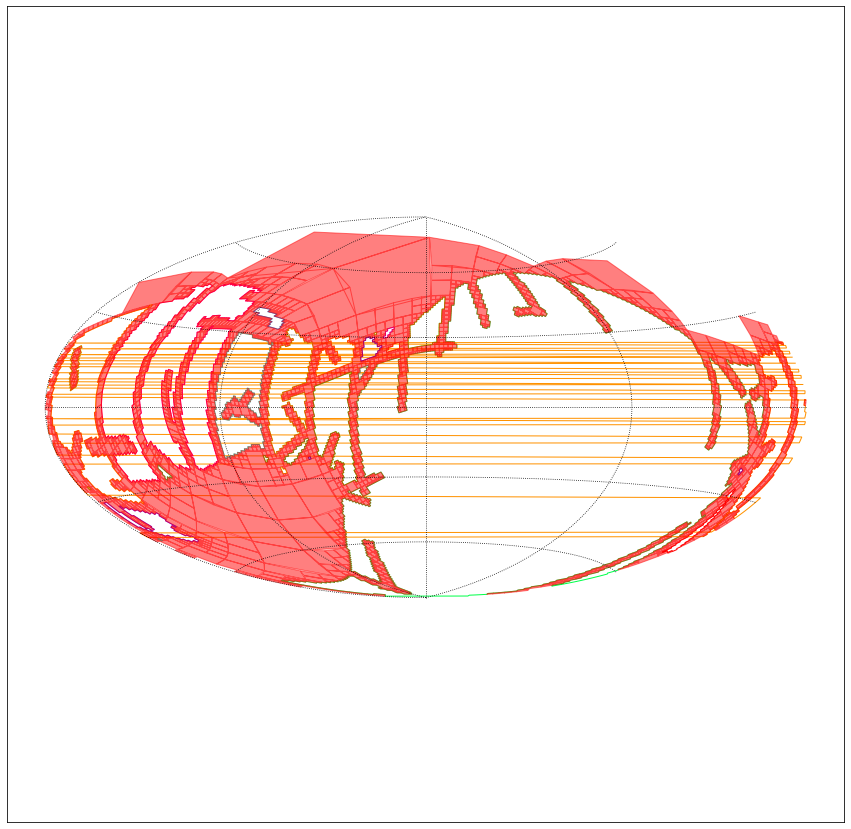

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": wcs_galactic})
cmap = get_cmap(32)

def insert_edge(G, l1, l2, p1, p2):
    # Nodes are indexed by str(skycoord). When getting ordered nodes, one can retrieve back the skycoord instance
    # by accessing the python dict `pts_d`.
    try:
        # Avoid the special case where holes are touching to each other
        # 'x' belongs to the MOC
        # ' ' is part of the holes in the MOC
        #    |xxx
        #    |xxx
        # ---A--- 
        # xxx|
        # xxx|
        #
        # If this case occurs we split the node A into 2. One is attached to the bottom left graph and the other to the
        # top right one. When computing the MST (minimal spanning tree) from a graph, we need our graphs to have
        # only nodes of degrees 1 or 2 (i.e. to be lines).
        if G.degree[l1] >= 2:
            l1 += '_'
    except:
        pass

    try:
        if G.degree[l2] >= 2:
            l2 += '_'
    except:
        pass
    # Set the skycoord instance as an attribute of the nodes
    V.add_node(l1, ra=p1.ra.deg, dec=p1.dec.deg)
    V.add_node(l2, ra=p2.ra.deg, dec=p2.dec.deg)
    V.add_edge(l1, l2)

# Split the global MOC graph into all its non connected subgraphs.
G_subgraphs = nx.connected_components(G)
for g in G_subgraphs:
    print('Phase 1: Retrieve the ipixels located at the border of this connexe MOC component')
    ipixels = np.asarray(list(g))

    neighbours = hp.neighbours(ipixels)[[0, 2, 4, 6], :]
    isin = np.isin(neighbours, ipixels)
    border = isin.sum(axis=0) < 4

    ipixels_border = ipixels[border]
    isin_border = isin[:, border]
    print('Phase 1 finished')
    
    print('Phase 2: Build the graph of ipix boundaries skycoord')
    ipixels_border_bounds = hp.boundaries_skycoord(ipixels_border, step=1)
    # Build the graph from the positions of the ipixels boundaries
    V = nx.Graph()
    nodes = []
    edges = []
    for i in range(ipixels_border.shape[0]):
        ipix = ipixels_border[i]
        ipix_bound = ipixels_border_bounds[i]
        
        p0 = ipix_bound[0]
        p1 = ipix_bound[1]
        p2 = ipix_bound[2]
        p3 = ipix_bound[3]
        s0 = str(p0)
        s1 = str(p1)
        s2 = str(p2)
        s3 = str(p3)
        
        # WEST border
        if not isin_border[0, i]:
            insert_edge(V, s1, s2, p1, p2)
            
        # NORTH border
        if not isin_border[3, i]:
            insert_edge(V, s2, s3, p2, p3)
            
        # EAST border
        if not isin_border[2, i]:
            insert_edge(V, s3, s0, p3, p0)
            
        # SOUTH border
        if not isin_border[1, i]:
            insert_edge(V, s0, s1, p0, p1)
    
    print('Phase 2 finished')
    print('Phase 3: Retrieve the skycoords from the graph')
    # Accessing the borders one by one. At this step, V_subgraphs contains a list of cycles
    # (i.e. one describing the external border of the MOC component and several describing the holes
    # found in the MOC component).
    V_subgraphs = nx.connected_component_subgraphs(V)
    for v in V_subgraphs:
        # Compute the MST for each cycle
        v = nx.convert_node_labels_to_integers(v)
        mst = nx.minimum_spanning_tree(v)
        # Get one end of the span tree by looping over its node and checking if the degree is one
        src = None
        for (node, deg) in mst.degree():
            if deg == 1:
                src = node
                break

        # Get the unordered coords
        ra = np.asarray(list(nx.get_node_attributes(v, 'ra').values()))
        dec = np.asarray(list(nx.get_node_attributes(v, 'dec').values()))
        coords = np.vstack((ra, dec)).T
        # Get the ordered nodes
        ordering = np.asarray(list(nx.dfs_preorder_nodes(mst, src)))
        # Order the coords
        coords = coords[ordering]
        # Convert them to a unique skycoord because it is currently a list of Skycoord
        coords = SkyCoord(coords, unit="deg")
        
        color = cmap(np.random.randint(32))
        # p_coords_lon/lat follow the perimeter and can be plotted using a MPL path patch
        add_patch_path_skycoord(ax, wcs_galactic, coords, color=color, fill=False)

    print('Phase 3 finished')

# Init the plot
print("Draw all the borders")
# Draw the MOC
moc.fill(ax=ax, wcs=wcs_galactic, alpha=0.5, fill=True, color='r')
plt.axis('equal')
plt.xlabel('ra')
plt.ylabel('dec')
plt.grid(color="black", linestyle="dotted")
# Show the plot
plt.show()